### Experiment:  Impact of HYDE implementation on context retrieval distance

**Background:**
HYDE (Hypothetical Document Embedding) is an approach that has been indicated to improve the relevancy and comprehensiveness of RAG context retrieval by expanding a provided query prompt into a hypothetical document that can be used for context retrieval.

**Test Approach**
A sample of questions will be selected from QA corpus.  Documents will be retrieved both via original question and via hypothetical document.  The resulting cosine similarity of original vs. hypothetical documents will be compared.  It is expected that context's retrieved via hypothetical document will have lower "distance" values.


In [13]:
import sys
print(sys.executable)

# Common import
from deh.assessment import QASetRetriever
from deh import settings
from deh.eval import generate_experiment_dataset

import pandas as pd
import os
from pathlib import Path

/home/knightal/deh_m/bin/python


#### Test Configuration

In [15]:
num_samples:int = 100
experiment_folder:str = "../../data/evaluations/hyde-experiment/"
qa_data_set_file:str = "../../data/qas/squad_qas.tsv"

# Create experiment folder:
if not os.path.exists(experiment_folder):
    Path(experiment_folder).mkdir(parents=True, exist_ok=True)


#### Sample QA dataset

In [9]:
qa_set = QASetRetriever.get_qasets(
    file_path = qa_data_set_file,
    sample_size= num_samples
)

print(f"{len(qa_set)} questions sampled from QA corpus ({qa_data_set_file})")

100 questions sampled from QA corpus (../../data/qas/squad_qas.tsv)


#### Get Similiarity Scores based on original question

In [19]:

def convert(response) -> pd.DataFrame:
    """Converts retrieved JSON response to Pandas DataFrame"""
    return pd.json_normalize(
        data=response["response"], record_path="context", meta=["question"]
    )

def api_endpoint(**kwargs) -> str:
    """Endpoint for context retrieval."""
    query_params = "&".join([f"{key}={kwargs[key]}" for key in kwargs])
    return f"http://{settings.API_ANSWER_ENDPOINT}/context_retrieval?{query_params}"

# Collect response:
exp_df = generate_experiment_dataset(qa_set, convert, api_endpoint)

# Store dataframe:
exp_df.to_pickle( f"{experiment_folder}/context_retrieval.pkl" )
exp_df[0:1]


Processing 1 of 100 question/answer pairs.
Processing 2 of 100 question/answer pairs.
Processing 3 of 100 question/answer pairs.
Processing 4 of 100 question/answer pairs.
Processing 5 of 100 question/answer pairs.
Processing 6 of 100 question/answer pairs.
Processing 7 of 100 question/answer pairs.
Processing 8 of 100 question/answer pairs.
Processing 9 of 100 question/answer pairs.
Processing 10 of 100 question/answer pairs.
Processing 11 of 100 question/answer pairs.
Processing 12 of 100 question/answer pairs.
Processing 13 of 100 question/answer pairs.
Processing 14 of 100 question/answer pairs.
Processing 15 of 100 question/answer pairs.
Processing 16 of 100 question/answer pairs.
Processing 17 of 100 question/answer pairs.
Processing 18 of 100 question/answer pairs.
Processing 19 of 100 question/answer pairs.
Processing 20 of 100 question/answer pairs.
Processing 21 of 100 question/answer pairs.
Processing 22 of 100 question/answer pairs.
Processing 23 of 100 question/answer pair

,id,page_content,type,metadata.source,metadata.similarity_score,question
0,None,Both before and after the 1708 passage of the ...,Document,/data/contexts/context_204.context,0.383104,About how many Walloons and Huguenots emigrate...


#### Get Similiarity Scores based on HYDE question

In [20]:
def hyde_convert(response) -> pd.DataFrame:
    """Converts retrieved JSON response to Pandas DataFrame"""
    return pd.json_normalize(
        data=response["response"],
        record_path="context",
        meta=["original_question", "question"],
    )

def hyde_api_endpoint(**kwargs) -> str:
    """Endpoint for context retrieval w/ hyde."""
    query_params = "&".join([f"{key}={kwargs[key]}" for key in kwargs])
    return (
        f"http://{settings.API_ANSWER_ENDPOINT}/context_retrieval?h=True&{query_params}"
    )

# Collect response:
exp_df = generate_experiment_dataset(qa_set, hyde_convert, hyde_api_endpoint)

# Store dataframe:
exp_df.to_pickle( f"{experiment_folder}/hyde_retrieval.pkl" )
exp_df[0:1]

Processing 1 of 100 question/answer pairs.
Processing 2 of 100 question/answer pairs.
Processing 3 of 100 question/answer pairs.
Processing 4 of 100 question/answer pairs.
Processing 5 of 100 question/answer pairs.
Processing 6 of 100 question/answer pairs.
Processing 7 of 100 question/answer pairs.
Processing 8 of 100 question/answer pairs.
Processing 9 of 100 question/answer pairs.
Processing 10 of 100 question/answer pairs.
Processing 11 of 100 question/answer pairs.
Processing 12 of 100 question/answer pairs.
Processing 13 of 100 question/answer pairs.
Processing 14 of 100 question/answer pairs.
Processing 15 of 100 question/answer pairs.
Processing 16 of 100 question/answer pairs.
Processing 17 of 100 question/answer pairs.
Processing 18 of 100 question/answer pairs.
Processing 19 of 100 question/answer pairs.
Processing 20 of 100 question/answer pairs.
Processing 21 of 100 question/answer pairs.
Processing 22 of 100 question/answer pairs.
Processing 23 of 100 question/answer pair

,id,page_content,type,metadata.source,metadata.similarity_score,original_question,question
0,None,The bulk of Huguenot émigrés relocated to Prot...,Document,/data/contexts/context_207.context,0.282335,About how many Walloons and Huguenots emigrate...,**The Migration of Walloons and Huguenots to E...


#### Load and merge Experiment Datasets for comparison

In [16]:
# Load experiment results:
context_retr_df = pd.read_pickle(f"{experiment_folder}/context_retrieval.pkl")
hyde_retr_df = pd.read_pickle(f"{experiment_folder}/hyde_retrieval.pkl")

In [17]:
# Concatenate datasets together for comparison:

context_retr_df["q_index"] = context_retr_df["question"]
context_retr_df["q_rank"] = context_retr_df.groupby(["q_index"]).cumcount()+1
context_retr_df.reset_index(drop=True)
hyde_retr_df["q_index"] = hyde_retr_df["original_question"]
hyde_retr_df["q_rank"] = hyde_retr_df.groupby(["q_index"]).cumcount()+1
hyde_retr_df.reset_index(drop=True)

combined_df = pd.merge( context_retr_df,hyde_retr_df, on=["q_index", "q_rank"], suffixes=["", "_hyde"])
combined_df[0:2]

,id,page_content,type,metadata.source,metadata.similarity_score,question,q_index,q_rank,id_hyde,page_content_hyde,type_hyde,metadata.source_hyde,metadata.similarity_score_hyde,original_question,question_hyde
0,None,Both before and after the 1708 passage of the ...,Document,/data/contexts/context_204.context,0.383104,About how many Walloons and Huguenots emigrate...,About how many Walloons and Huguenots emigrate...,1,None,The bulk of Huguenot émigrés relocated to Prot...,Document,/data/contexts/context_207.context,0.282335,About how many Walloons and Huguenots emigrate...,**The Migration of Walloons and Huguenots to E...
1,None,The bulk of Huguenot émigrés relocated to Prot...,Document,/data/contexts/context_207.context,0.429309,About how many Walloons and Huguenots emigrate...,About how many Walloons and Huguenots emigrate...,2,None,Both before and after the 1708 passage of the ...,Document,/data/contexts/context_204.context,0.303946,About how many Walloons and Huguenots emigrate...,**The Migration of Walloons and Huguenots to E...


In [19]:
# Compare if the hyde similarity is better than raw question (lower is better):
combined_df["similarity_delta"] = combined_df["metadata.similarity_score_hyde"] - combined_df["metadata.similarity_score"]

# Compare if same context was selected (hypothesis that would be different):
combined_df["same_context"] = combined_df["metadata.source_hyde"] == combined_df["metadata.source"]
combined_df[["similarity_delta","same_context"]][0:5]

,similarity_delta,same_context
0,-0.100770,False
1,-0.125363,False
2,-0.145865,False
3,-0.119621,False
4,-0.156142,False


##### Number of contexts in same position


In [20]:
# Percent of same:
len( combined_df[ combined_df["same_context"] == True ] ) / len (combined_df) * 100

27.192982456140353

##### Number of recos with higher similarity via HYDE

In [21]:
len ( combined_df[ combined_df["similarity_delta"] < 0 ]) / len(combined_df) * 100

84.73684210526315

<Axes: >

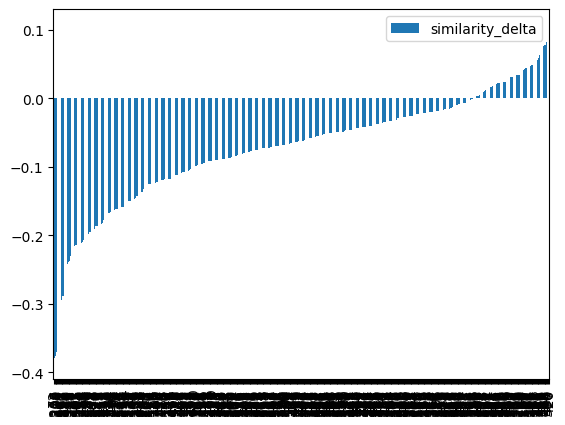

In [23]:
combined_df.sort_values(by=["similarity_delta"]).plot(kind="bar", y="similarity_delta")